<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/10_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 10 - Time Series

![](https://sthalles.github.io/assets/time-series-decomposition/cover.png)

# Install

In [1]:
!pip install pmdarima

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

import pmdarima as pm
from pmdarima.arima import AutoARIMA

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

# Pandas
* Built in support for ingesting date like fields through pd.read_csv and pd.to_datetime
* read_csv offers several flags to control parsing
  through parse_dates
  * List = Parse these columns as dates
  * List of Lists = Combine these columns and parse
  * Dict = Combine these columns and place result in column
* If your date data from a csv is irregular, call read_csv, then correct using to_datetime
* dayfirst controls for International / European date formatting

In [4]:
# Parse Dates
data = ['2020-01-01', '2020-02-01', '2020-03-01']
pd.to_datetime(data)

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq=None)

## Epoch Times
* Pandas can convert EPOCH times (milliseconds from epoch)
* Time elapsed from 1970-01-01T00:00:00Z
* Length (10 = seconds, 13 milli, 16 micro)

In [5]:
# Convert 1349892910
pd.to_datetime(1349892910000, unit='ms')

Timestamp('2012-10-10 18:15:10')

## Parsing Errors

In [6]:
# Errors
dates = ['2020-01-01', '2021-Error', '2022-01-01']
try:
  pd.to_datetime(dates)
except Exception as e:
  print(e)

Unknown string format: 2021-Error


In [7]:
# Coerce - forces parse errors to NaT
dates = ['2020-01-01', '2021-Error', '2022-01-01']
pd.to_datetime(dates, errors='coerce')

DatetimeIndex(['2020-01-01', 'NaT', '2022-01-01'], dtype='datetime64[ns]', freq=None)

In [8]:
# Ignore will leave the original value intact
dates = ['2020-01-01', '2021-Error', '2022-01-01']
pd.to_datetime(dates, errors='ignore')

Index(['2020-01-01', '2021-Error', '2022-01-01'], dtype='object')

## Ranges

In [9]:
# Create a range using start & end
pd.date_range(start='1960-01-01', end='1961-12-31', freq='MS')

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01',
               '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [10]:
# Create a range for fixed number of periods
# Note:  freq=M is end of month.  Use freq=MS for start of month
pd.date_range(start='1960-01-01', periods=24, freq='M')

DatetimeIndex(['1960-01-31', '1960-02-29', '1960-03-31', '1960-04-30',
               '1960-05-31', '1960-06-30', '1960-07-31', '1960-08-31',
               '1960-09-30', '1960-10-31', '1960-11-30', '1960-12-31',
               '1961-01-31', '1961-02-28', '1961-03-31', '1961-04-30',
               '1961-05-31', '1961-06-30', '1961-07-31', '1961-08-31',
               '1961-09-30', '1961-10-31', '1961-11-30', '1961-12-31'],
              dtype='datetime64[ns]', freq='M')

## TimeZones
* To UTC
* To Local

In [11]:
# Create some times to work with
example = pd.date_range(start='2020-01-01', periods=12, freq='H')
example

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               '2020-01-01 10:00:00', '2020-01-01 11:00:00'],
              dtype='datetime64[ns]', freq='H')

In [12]:
# Localize them to US/Eastern
eastern = example.tz_localize('US/Eastern')
eastern

DatetimeIndex(['2020-01-01 00:00:00-05:00', '2020-01-01 01:00:00-05:00',
               '2020-01-01 02:00:00-05:00', '2020-01-01 03:00:00-05:00',
               '2020-01-01 04:00:00-05:00', '2020-01-01 05:00:00-05:00',
               '2020-01-01 06:00:00-05:00', '2020-01-01 07:00:00-05:00',
               '2020-01-01 08:00:00-05:00', '2020-01-01 09:00:00-05:00',
               '2020-01-01 10:00:00-05:00', '2020-01-01 11:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', freq=None)

In [13]:
# Convert to UTC
utc = eastern.tz_convert('UTC')
utc

DatetimeIndex(['2020-01-01 05:00:00+00:00', '2020-01-01 06:00:00+00:00',
               '2020-01-01 07:00:00+00:00', '2020-01-01 08:00:00+00:00',
               '2020-01-01 09:00:00+00:00', '2020-01-01 10:00:00+00:00',
               '2020-01-01 11:00:00+00:00', '2020-01-01 12:00:00+00:00',
               '2020-01-01 13:00:00+00:00', '2020-01-01 14:00:00+00:00',
               '2020-01-01 15:00:00+00:00', '2020-01-01 16:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [14]:
# Convert to US/Pacific
utc.tz_convert('US/Pacific')

DatetimeIndex(['2019-12-31 21:00:00-08:00', '2019-12-31 22:00:00-08:00',
               '2019-12-31 23:00:00-08:00', '2020-01-01 00:00:00-08:00',
               '2020-01-01 01:00:00-08:00', '2020-01-01 02:00:00-08:00',
               '2020-01-01 03:00:00-08:00', '2020-01-01 04:00:00-08:00',
               '2020-01-01 05:00:00-08:00', '2020-01-01 06:00:00-08:00',
               '2020-01-01 07:00:00-08:00', '2020-01-01 08:00:00-08:00'],
              dtype='datetime64[ns, US/Pacific]', freq=None)

In [15]:
# Remove the Timezone
utc.tz_localize(None)

DatetimeIndex(['2020-01-01 05:00:00', '2020-01-01 06:00:00',
               '2020-01-01 07:00:00', '2020-01-01 08:00:00',
               '2020-01-01 09:00:00', '2020-01-01 10:00:00',
               '2020-01-01 11:00:00', '2020-01-01 12:00:00',
               '2020-01-01 13:00:00', '2020-01-01 14:00:00',
               '2020-01-01 15:00:00', '2020-01-01 16:00:00'],
              dtype='datetime64[ns]', freq=None)

# Shampoo
* https://www.kaggle.com/redwankarimsony/shampoo-saled-dataset

## Download

In [16]:
!wget -O shampoo.zip https://github.com/swilsonmfc/pandas/raw/main/shampoo.zip
!unzip ./shampoo.zip

--2021-08-31 13:40:59--  https://github.com/swilsonmfc/pandas/raw/main/shampoo.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/swilsonmfc/pandas/main/shampoo.zip [following]
--2021-08-31 13:41:00--  https://raw.githubusercontent.com/swilsonmfc/pandas/main/shampoo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392 [application/zip]
Saving to: ‘shampoo.zip’

shampoo.zip         100%[===================>]     392  --.-KB/s    in 0s      

2021-08-31 13:41:00 (27.1 MB/s) - ‘shampoo.zip’ saved [392/392]

Archive:  ./shampoo.zip
  inflating: shampoo_sales.csv       


## EDA

In [17]:
shampoo_df = pd.read_csv('shampoo_sales.csv')
shampoo_df

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


In [18]:
# Times are in a string (year + month) format
shampoo_df.dtypes

Month     object
Sales    float64
dtype: object

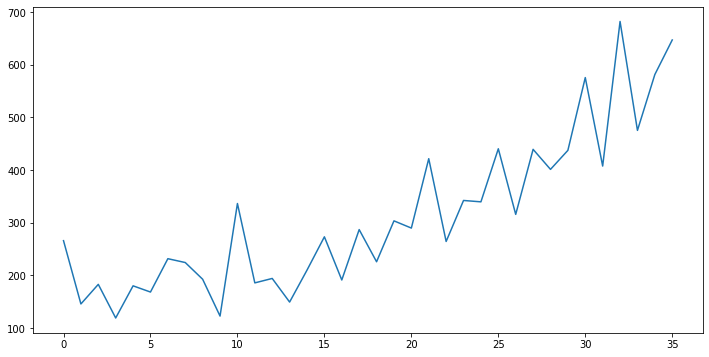

In [19]:
shampoo_df.Sales.plot();

## Date Formats

In [20]:
# Let's get these into a time format
shampoo_df['Year_Month'] = '200' + shampoo_df.Month
shampoo_df.head()

,Month,Sales,Year_Month
0,1-01,266.0,2001-01
1,1-02,145.9,2001-02
2,1-03,183.1,2001-03
3,1-04,119.3,2001-04
4,1-05,180.3,2001-05


In [21]:
# Create a datetime field
shampoo_df['Sales_Month'] = pd.to_datetime(shampoo_df.Year_Month)

In [22]:
# Accessing datetime functionality
shampoo_df.Sales_Month.dt.year

0     2001
1     2001
2     2001
3     2001
4     2001
5     2001
6     2001
7     2001
8     2001
9     2001
10    2001
11    2001
12    2002
13    2002
14    2002
15    2002
16    2002
17    2002
18    2002
19    2002
20    2002
21    2002
22    2002
23    2002
24    2003
25    2003
26    2003
27    2003
28    2003
29    2003
30    2003
31    2003
32    2003
33    2003
34    2003
35    2003
Name: Sales_Month, dtype: int64

## Time Series Index

In [23]:
# Set index
shampoo_df = shampoo_df.set_index(pd.to_datetime(shampoo_df.Sales_Month))
shampoo_df

,Month,Sales,Year_Month,Sales_Month
Sales_Month,,,,
2001-01-01,1-01,266.0,2001-01,2001-01-01
2001-02-01,1-02,145.9,2001-02,2001-02-01
2001-03-01,1-03,183.1,2001-03,2001-03-01
2001-04-01,1-04,119.3,2001-04,2001-04-01
2001-05-01,1-05,180.3,2001-05,2001-05-01
2001-06-01,1-06,168.5,2001-06,2001-06-01
2001-07-01,1-07,231.8,2001-07,2001-07-01
2001-08-01,1-08,224.5,2001-08,2001-08-01
2001-09-01,1-09,192.8,2001-09,2001-09-01


## Slicing

In [24]:
# We can split on datetime ranges
shampoo_df[(shampoo_df.Sales_Month >= '2002-01-01') & (shampoo_df.Sales_Month < '2003-01-01')]

,Month,Sales,Year_Month,Sales_Month
Sales_Month,,,,
2002-01-01,2-01,194.3,2002-01,2002-01-01
2002-02-01,2-02,149.5,2002-02,2002-02-01
2002-03-01,2-03,210.1,2002-03,2002-03-01
2002-04-01,2-04,273.3,2002-04,2002-04-01
2002-05-01,2-05,191.4,2002-05,2002-05-01
2002-06-01,2-06,287.0,2002-06,2002-06-01
2002-07-01,2-07,226.0,2002-07,2002-07-01
2002-08-01,2-08,303.6,2002-08,2002-08-01
2002-09-01,2-09,289.9,2002-09,2002-09-01


In [25]:
shampoo_df.loc['2002-01-01' : '2002-12-31']

,Month,Sales,Year_Month,Sales_Month
Sales_Month,,,,
2002-01-01,2-01,194.3,2002-01,2002-01-01
2002-02-01,2-02,149.5,2002-02,2002-02-01
2002-03-01,2-03,210.1,2002-03,2002-03-01
2002-04-01,2-04,273.3,2002-04,2002-04-01
2002-05-01,2-05,191.4,2002-05,2002-05-01
2002-06-01,2-06,287.0,2002-06,2002-06-01
2002-07-01,2-07,226.0,2002-07,2002-07-01
2002-08-01,2-08,303.6,2002-08,2002-08-01
2002-09-01,2-09,289.9,2002-09,2002-09-01


In [26]:
# Slice iloc
shampoo_df.iloc[13 : 24]

,Month,Sales,Year_Month,Sales_Month
Sales_Month,,,,
2002-02-01,2-02,149.5,2002-02,2002-02-01
2002-03-01,2-03,210.1,2002-03,2002-03-01
2002-04-01,2-04,273.3,2002-04,2002-04-01
2002-05-01,2-05,191.4,2002-05,2002-05-01
2002-06-01,2-06,287.0,2002-06,2002-06-01
2002-07-01,2-07,226.0,2002-07,2002-07-01
2002-08-01,2-08,303.6,2002-08,2002-08-01
2002-09-01,2-09,289.9,2002-09,2002-09-01
2002-10-01,2-10,421.6,2002-10,2002-10-01


## Aggregating

In [27]:
# Sales Per Year
shampoo_df.groupby(shampoo_df.Sales_Month.dt.year)['Sales'].sum()

Sales_Month
2001    2357.5
2002    3153.5
2003    5742.6
Name: Sales, dtype: float64

In [28]:
# Aggregating - resample returns a DatetimeIndexResampler (think groupby) that we can build aggregates
shampoo_df.resample('Y').sum()

,Sales
Sales_Month,
2001-12-31,2357.5
2002-12-31,3153.5
2003-12-31,5742.6


In [29]:
# Resample supports flexible time ranges giving it more expressiveness over explicit groupby
shampoo_df.resample('6M').sum()

,Sales
Sales_Month,
2001-01-31,266.0
2001-07-31,1028.9
2002-01-31,1256.9
2002-07-31,1337.3
2003-01-31,1961.6
2003-07-31,2609.8
2004-01-31,2793.1


In [30]:
# Resample supports agg
shampoo_df.resample('6M').agg({'Sales': ['sum', 'mean', 'std']})

Sales                        
                sum        mean         std
Sales_Month                                
2001-01-31    266.0  266.000000         NaN
2001-07-31   1028.9  171.483333   38.045468
2002-01-31   1256.9  209.483333   70.598085
2002-07-31   1337.3  222.883333   51.385267
2003-01-31   1961.6  326.933333   55.090350
2003-07-31   2609.8  434.966667   83.802331
2004-01-31   2793.1  558.620000  115.411901

## Frequency
* asfreq is similar to resample with some important differences
* resample is a grouping mechanism
* asfreq is more limited / filtering

In [31]:
# Illustrative time series
items = 31 + 28 + 31 + 30
ts = pd.Series(range(items), index = pd.date_range(start='20210101', 
                                                end='20210430',
                                                freq = 'D'))
ts

2021-01-01      0
2021-01-02      1
2021-01-03      2
2021-01-04      3
2021-01-05      4
             ... 
2021-04-26    115
2021-04-27    116
2021-04-28    117
2021-04-29    118
2021-04-30    119
Freq: D, Length: 120, dtype: int64

In [32]:
# Adjusting the frequency to monthly returns the last value of each monthly "bin"
ts.asfreq(freq='M')

2021-01-31     30
2021-02-28     58
2021-03-31     89
2021-04-30    119
Freq: M, dtype: int64

In [33]:
# Resample returns a DateTimeIndexResampler
ts.resample(rule='M')

In [34]:
# Compute average on asfreq
# Returns the average of the four last values (30 + 58 + 89 + 119) / 4
ts.asfreq(freq='M').mean()

74.0

In [35]:
# Compute average on resample
# Returns the average value in each "bin" (month)
ts.resample(rule='M').mean()

2021-01-31     15.0
2021-02-28     44.5
2021-03-31     74.0
2021-04-30    104.5
Freq: M, dtype: float64

## Shifting
* Positive pushes ahead
* Negative pulls back

In [36]:
# Month over Month % Change
mom_df = shampoo_df[['Sales']].copy()
mom_df['Last'] = mom_df.Sales.shift(1)
mom_df['Percent_Change'] = (mom_df.Sales - mom_df.Last) * 100. / mom_df.Last
mom_df

,Sales,Last,Percent_Change
Sales_Month,,,
2001-01-01,266.0,NaN,NaN
2001-02-01,145.9,266.0,-45.150376
2001-03-01,183.1,145.9,25.496916
2001-04-01,119.3,183.1,-34.844347
2001-05-01,180.3,119.3,51.131601
2001-06-01,168.5,180.3,-6.544648
2001-07-01,231.8,168.5,37.566766
2001-08-01,224.5,231.8,-3.149267
2001-09-01,192.8,224.5,-14.120267


## Window - Rolling

In [37]:
# 3 Month Moving Average 
mv = shampoo_df.rolling(3)['Sales'].mean()
mv

Sales_Month
2001-01-01           NaN
2001-02-01           NaN
2001-03-01    198.333333
2001-04-01    149.433333
2001-05-01    160.900000
2001-06-01    156.033333
2001-07-01    193.533333
2001-08-01    208.266667
2001-09-01    216.366667
2001-10-01    180.066667
2001-11-01    217.400000
2001-12-01    215.100000
2002-01-01    238.900000
2002-02-01    176.566667
2002-03-01    184.633333
2002-04-01    210.966667
2002-05-01    224.933333
2002-06-01    250.566667
2002-07-01    234.800000
2002-08-01    272.200000
2002-09-01    273.166667
2002-10-01    338.366667
2002-11-01    325.333333
2002-12-01    342.800000
2003-01-01    315.500000
2003-02-01    374.133333
2003-03-01    365.333333
2003-04-01    398.533333
2003-05-01    385.500000
2003-06-01    426.000000
2003-07-01    471.400000
2003-08-01    473.500000
2003-09-01    555.033333
2003-10-01    521.633333
2003-11-01    579.533333
2003-12-01    567.833333
Name: Sales, dtype: float64

## Window - Expanding
* Window that includes all data up to that point

In [38]:
# Expand monthly
# 3 Month Expanding
ex = shampoo_df.expanding(3)['Sales'].mean()
ex

Sales_Month
2001-01-01           NaN
2001-02-01           NaN
2001-03-01    198.333333
2001-04-01    178.575000
2001-05-01    178.920000
2001-06-01    177.183333
2001-07-01    184.985714
2001-08-01    189.925000
2001-09-01    190.244444
2001-10-01    183.510000
2001-11-01    197.418182
2001-12-01    196.458333
2002-01-01    196.292308
2002-02-01    192.950000
2002-03-01    194.093333
2002-04-01    199.043750
2002-05-01    198.594118
2002-06-01    203.505556
2002-07-01    204.689474
2002-08-01    209.635000
2002-09-01    213.457143
2002-10-01    222.918182
2002-11-01    224.726087
2002-12-01    229.625000
2003-01-01    234.028000
2003-02-01    241.965385
2003-03-01    244.703704
2003-04-01    251.653571
2003-05-01    256.813793
2003-06-01    262.833333
2003-07-01    272.919355
2003-08-01    277.128125
2003-09-01    289.396970
2003-10-01    294.864706
2003-11-01    303.048571
2003-12-01    312.600000
Name: Sales, dtype: float64

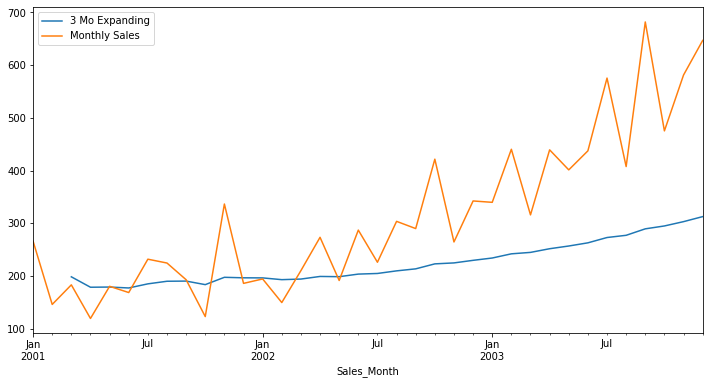

In [39]:
ex.plot(label='3 Mo Expanding')
shampoo_df.Sales.plot(label='Monthly Sales')
plt.legend();

## Missing Values

In [40]:
# Drop out a couple of rows in the frame
# To drop, we have to use Timestamps, create a list of them and drop
missing = shampoo_df[['Sales']].copy()
labels = [pd.Timestamp(v) for v in ['2001-09-01', '2002-09-01', '2003-09-01']]
missing = missing.drop(index=labels)
missing.head(12)

,Sales
Sales_Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-10-01,122.9


In [41]:
# Use resample to bring back missing periods
missing.resample('M').mean().head(12)

,Sales
Sales_Month,
2001-01-31,266.0
2001-02-28,145.9
2001-03-31,183.1
2001-04-30,119.3
2001-05-31,180.3
2001-06-30,168.5
2001-07-31,231.8
2001-08-31,224.5
2001-09-30,NaN


In [42]:
# Run asfreq using Month Start
missing.asfreq(freq='MS').head(12)

,Sales
Sales_Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,NaN


In [43]:
# Replace NaN with set value
fill = missing.asfreq(freq='MS').copy()
fill.fillna(-1).head(12)

,Sales
Sales_Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,-1.0


In [44]:
# Forward / Backward Fill (Backward fill)
fill = missing.asfreq(freq='MS').copy()
fill.fillna(method='bfill').head(12)

,Sales
Sales_Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,122.9


In [45]:
# Interpolate Linear ... (244.5 + 122.9) / 2
fill = missing.asfreq(freq='MS').copy()
fill.interpolate().head(12)

,Sales
Sales_Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,173.7


# Sales

## Download

In [46]:
!wget -O sales.csv https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv

--2021-08-31 13:41:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317399 (310K) [application/x-httpd-php]
Saving to: ‘sales.csv’

sales.csv           100%[===================>] 309.96K  --.-KB/s    in 0.05s   

2021-08-31 13:41:01 (5.75 MB/s) - ‘sales.csv’ saved [317399/317399]



## EDA

In [47]:
sales_df = pd.read_csv('sales.csv')
sales_df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,...,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,...,0.72,0.33,0.33,0.33,0.61,0.33,0.00,0.50,0.11,0.44,0.22,0.50,0.11,0.33,0.22,0.39,0.11,0.44,0.22,0.39,0.50,0.17,0.11,0.61,0.39,0.33,0.50,0.78,0.22,0.44,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,...,0.60,0.20,0.00,0.60,0.20,0.70,0.70,0.90,0.40,0.70,0.20,0.40,0.50,0.30,0.50,0.80,0.50,0.50,0.30,0.10,0.30,0.20,0.30,1.00,0.50,0.20,0.70,0.30,0.20,0.50,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,...,0.09,0.36,0.82,0.45,0.36,0.73,0.64,0.36,0.36,0.91,0.73,0.45,0.64,0.45,1.00,0.18,0.00,0.91,0.73,0.55,0.36,0.45,0.36,0.55,0.27,0.82,0.82,0.55,0.00,0.18,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,...,0.18,0.12,0.76,0.29,0.53,0.41,0.76,0.12,0.24,0.29,0.53,0.29,0.41,0.24,0.47,0.47,0.00,0.24,0.29,0.00,0.18,0.59,0.18,1.00,0.35,0.24,0.35,0.35,0.59,0.24,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,...,0.33,0.07,0.67,0.33,0.47,0.80,0.20,0.67,0.53,0.20,0.47,0.40,0.33,0.60,0.33,0.40,0.67,0.00,0.13,0.00,0.13,0.13,0.40,0.27,0.07,0.33,0.33,0.13,0.13,0.33,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,1,0,0,1,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,...,0.33,0.00,0.33,0.33,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.67,0.33,0.00,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,1,0,2,2,0,5,1,1,1,2,3,1,0,2,1,7,3,3,3,2,2,3,1,1,4,5,4,3,2,4,...,0.29,0.00,0.71,0.14,0.14,0.14,0.29,0.43,0.14,0.00,0.29,0.14,1.00,0.43,0.43,0.43,0.29,0.29,0.43,0.14,0.14,0.57,0.71,0.57,0.43,0.29,0.57,0.86,0.86,1.00,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,1,0,1,1,0,1,1,1,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.50,0.00,1.00,0.50,0.50,0.00,0.50,0.50,0.00,0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


## Transform

In [48]:
def product_ts(product):
  # Select Product 1, Take weekly raw values, Synthesize a TimeIndex and Transpose
  product_df = sales_df[sales_df.Product_Code == product]
  product_df = product_df[[f'W{i}' for i in range(52)]].T
  product_df.index = pd.date_range('2000-01-01', freq='MS', periods=52)
  product_df.columns = ['Sales']
  return product_df
product_df = product_ts('P1')

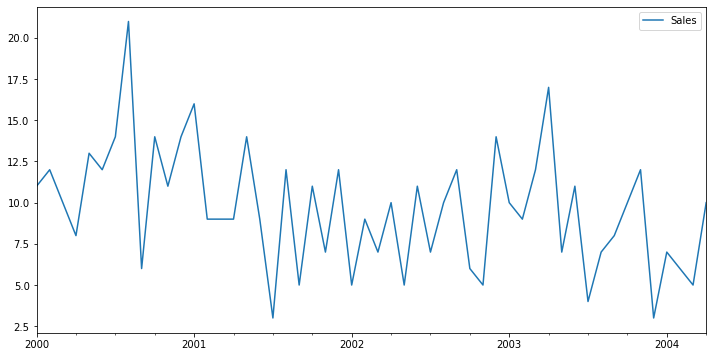

In [49]:
product_df.plot()

# Smoothing

## Product

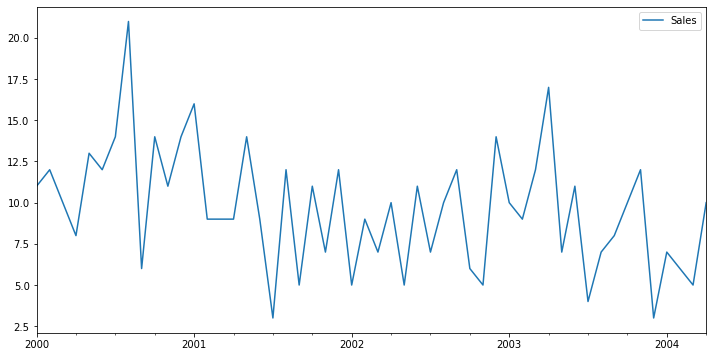

In [50]:
product_df = product_ts('P1')
product_df.plot()

## Decomposition

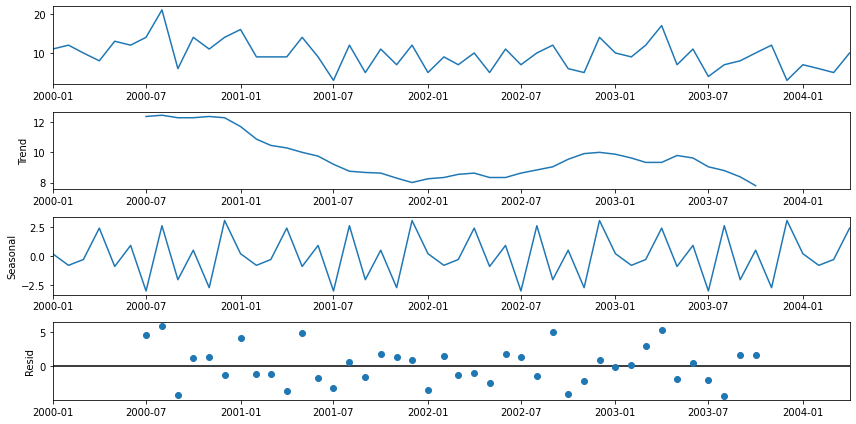

In [51]:
additive = seasonal_decompose(product_df, model='additive')
additive.plot();

## Moving Averages

In [52]:
ma = product_df.rolling(window=12).mean()

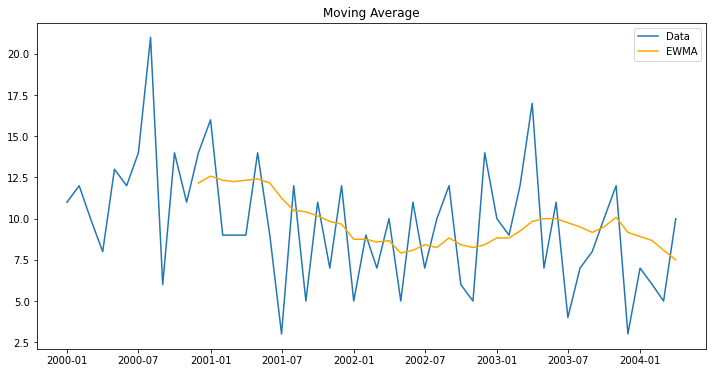

In [53]:
plt.plot(product_df, label='Data')
plt.plot(ma, color='orange', label='EWMA')
plt.legend()
plt.title('Moving Average');

## Exponential Weighted Average

In [54]:
ewma = product_df.ewm(span=12).mean()

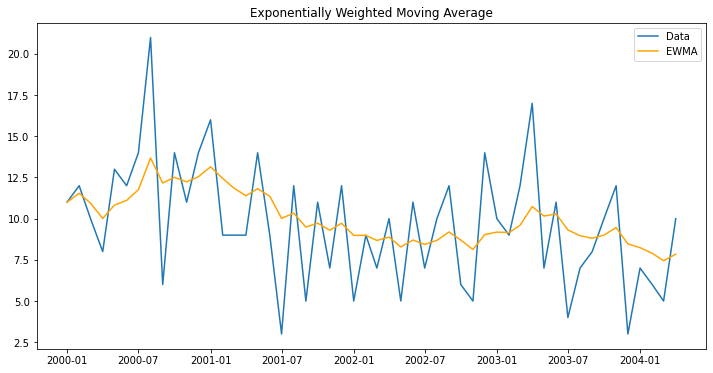

In [55]:
plt.plot(product_df, label='Data')
plt.plot(ewma, color='orange', label='EWMA')
plt.legend()
plt.title('Exponentially Weighted Moving Average');

## Exponential Smoothing

$
\begin{align}
\alpha * y_t + (1-\alpha) * y_{t-1}
\end{align}
$

* Assigns exponentially decreasing weights to past observations
* Restricted version of Exponential Smoothing
Implemented in the SimpleExpSmoothing as subclass of ExponentialSmoothing
* Good choice when:
  * No clear trend
  * No seasonal pattern
* Forecasted values are generated from weighted averages
Weights controled by smoothing parameter
  * alpha (Range 0 .. 1)
  * alpha close to 1 assigns weight to recent observations
  * alpha close to 0 assigns weight to average historical data

In [56]:
results_df = pd.DataFrame(columns=['SSE', 'AIC'])

### AIC
* Helps guide the tradeoff between model complexity and accuracy
* Not absolute - doesn't grade model goodness, but can help pick best of the worst
* AIC = -2(log-likelihood) + 2K
* log-likelihood is the goodness of fit (bigger is better)
* K is the number of parameters used
* Intuition:
  * Two models
  * Model 1 needs 2 features and has a log-likelihood of 100
  * Model 1 = -2(100) + 2*2 = -196
  * Model 2 uses 10 features and has a log-likelihood of 105
  * Model 2 = -2(105) + 2*10 = -190
  * Favor Model 1 

### Naive Model
* When alpha is set to 1 we forecast the last value
* We can see that we are just one period offset
* Assumes past is a perfect future predictor

In [57]:
model_naive = SimpleExpSmoothing(product_df).fit(smoothing_level=1.0, optimized=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [58]:
results_df.loc['Simple:Naive'] = [model_naive.sse, model_naive.aic]
model_naive.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,SimpleExpSmoothing,SSE,1385.000
Optimized:,False,AIC,174.675
Trend:,None,BIC,178.577
Seasonal:,None,AICC,175.526
Seasonal Periods:,None,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,False
initial_level,11.000000,l.0,False


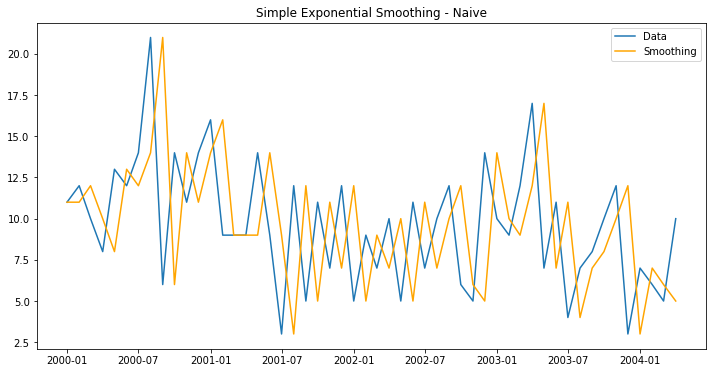

In [59]:
plt.plot(product_df, label='Data')
plt.plot(model_naive.fittedvalues, color='orange', label='Smoothing')
plt.legend()
plt.title('Simple Exponential Smoothing - Naive');

### Historic Average

In [60]:
model_average = SimpleExpSmoothing(product_df).fit(smoothing_level=0.0, optimized=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [61]:
results_df.loc['Simple:Average'] = [model_average.sse, model_average.aic]
model_average.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,SimpleExpSmoothing,SSE,793.000
Optimized:,False,AIC,145.678
Trend:,None,BIC,149.581
Seasonal:,None,AICC,146.529
Seasonal Periods:,None,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.000000,alpha,False
initial_level,11.000000,l.0,False


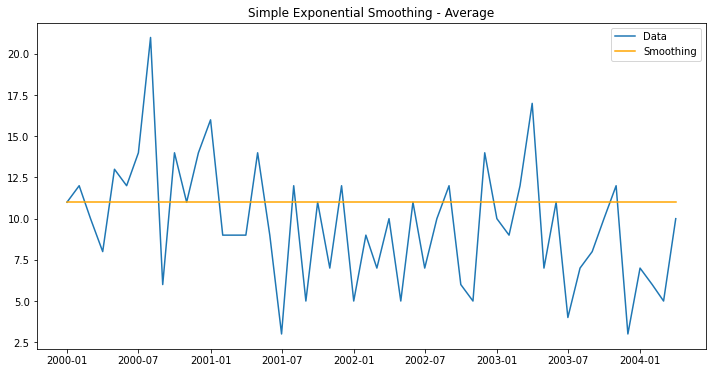

In [62]:
plt.plot(product_df, label='Data')
plt.plot(model_average.fittedvalues, color='orange', label='Smoothing')
plt.legend()
plt.title('Simple Exponential Smoothing - Average');

### EWMA
* By setting alpha correctly we can reproduce an Exponentially Weighted Moving Average

In [63]:
span = 12
alpha = 2 / (span + 1)
model_ewma = SimpleExpSmoothing(product_df).fit(smoothing_level=alpha, optimized=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [64]:
results_df.loc['Simple:EWMA'] = [model_ewma.sse, model_ewma.aic]
model_ewma.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,SimpleExpSmoothing,SSE,680.388
Optimized:,False,AIC,137.714
Trend:,None,BIC,141.616
Seasonal:,None,AICC,138.565
Seasonal Periods:,None,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1538462,alpha,False
initial_level,11.000000,l.0,False


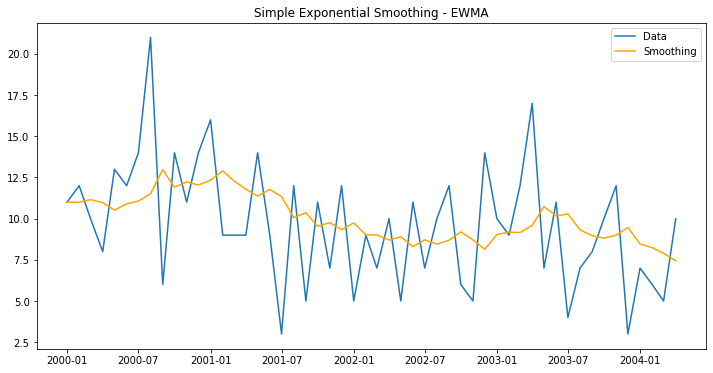

In [65]:
plt.plot(product_df, label='Data')
plt.plot(model_ewma.fittedvalues, color='orange', label='Smoothing')
plt.legend()
plt.title('Simple Exponential Smoothing - EWMA');

### Auto Optimization


In [66]:
model_auto = SimpleExpSmoothing(product_df).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [67]:
results_df.loc['Simple:Auto'] = [model_auto.sse, model_auto.aic]
model_auto.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,SimpleExpSmoothing,SSE,675.323
Optimized:,True,AIC,137.325
Trend:,None,BIC,141.228
Seasonal:,None,AICC,138.176
Seasonal Periods:,None,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1085429,alpha,True
initial_level,11.286021,l.0,True


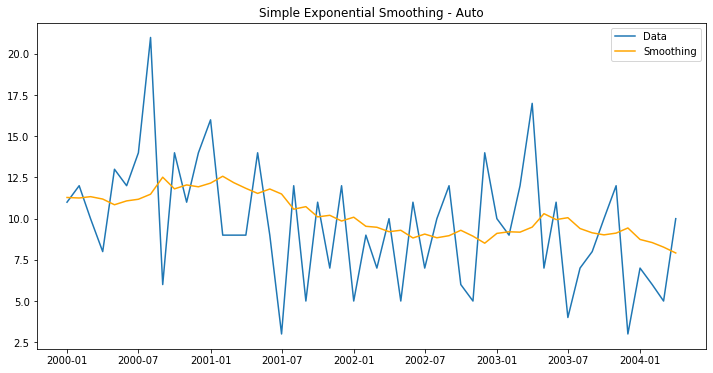

In [68]:
plt.plot(product_df, label='Data')
plt.plot(model_auto.fittedvalues, color='orange', label='Smoothing')
plt.legend()
plt.title('Simple Exponential Smoothing - Auto');

### Comparison

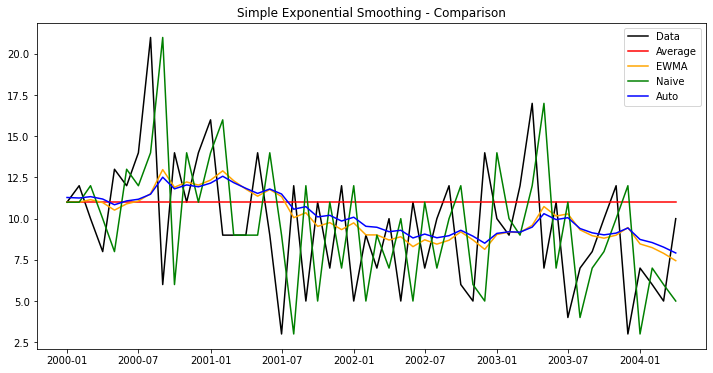

In [69]:
plt.plot(product_df, color='black', label='Data')
plt.plot(model_average.fittedvalues, color='red', label='Average')
plt.plot(model_ewma.fittedvalues, color='orange', label='EWMA')
plt.plot(model_naive.fittedvalues, color='green', label='Naive')
plt.plot(model_auto.fittedvalues, color='blue', label='Auto')
plt.legend()
plt.title('Simple Exponential Smoothing - Comparison');

## Holt
* Builds on SimpleExpSmoothing
* Double Exponential Smoothing
* Uses two smoothing equations
  * Level
  * Trend
* Can handle additive and multiplicative trends
* Can be damped

$$\begin{align*}
  \hat{y}_{t+h|t} = \ell_{t} + hb_{t}\\
  \ell_{t} = \alpha(y_{t}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
\end{align*}$$

In [70]:
holt_add = Holt(product_df)
holt_results = holt_add.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [71]:
results_df.loc['Holt'] = [holt_results.sse, holt_results.aic]
holt_results.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,Holt,SSE,604.867
Optimized:,True,AIC,135.596
Trend:,Additive,BIC,143.401
Seasonal:,None,AICC,137.462
Seasonal Periods:,None,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,2.5357e-09,beta,True


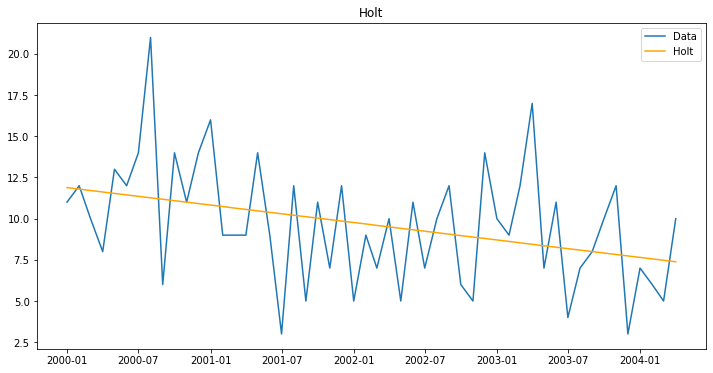

In [72]:
plt.plot(product_df, label='Data')
plt.plot(holt_results.fittedvalues, color='orange', label='Holt')
plt.legend()
plt.title('Holt');

## Holt Winters
* Holt-Winters is triple Exponential Smoothing
* Builds on Holt & uses three smoothing equations
  * Level
  * Trend
  * Seasonality
$$\begin{align*}
  \hat{y}_{t+h|t} = \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} = \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} = \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}$$

In [73]:
model_hw = ExponentialSmoothing(product_df, trend='additive', seasonal='additive').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [74]:
results_df.loc['HoltWinters'] = [model_hw.sse, model_hw.aic]
model_hw.summary()

Dep. Variable:,Sales,No. Observations:,52
Model:,ExponentialSmoothing,SSE,497.688
Optimized:,True,AIC,149.454
Trend:,Additive,BIC,180.674
Seasonal:,Additive,AICC,170.181
Seasonal Periods:,12,Date:,"Tue, 31 Aug 2021"
Box-Cox:,False,Time:,13:41:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,9.4775e-10,beta,True


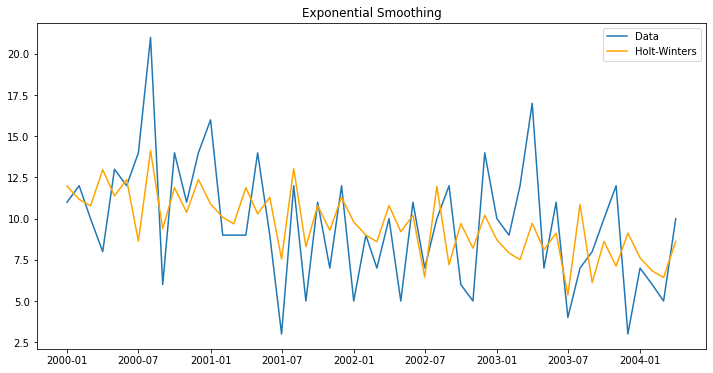

In [75]:
plt.plot(product_df, label='Data')
plt.plot(model_hw.fittedvalues, color='orange', label='Holt-Winters')
plt.legend()
plt.title('Exponential Smoothing');

## Comparison
* Min SSE vs Min AIC
* Trade-off

In [76]:
results_df.sort_values('AIC')

,SSE,AIC
Holt,604.866525,135.595733
Simple:Auto,675.322716,137.325242
Simple:EWMA,680.388054,137.713818
Simple:Average,793.000000,145.678134
HoltWinters,497.687507,149.453891
Simple:Naive,1385.000000,174.675008


## Predict

In [77]:
start = '2004-04-01'
end   = '2004-12-01'
future = model_ewma.predict(start=start, end=end)
future

2004-04-01    7.450407
2004-05-01    7.842652
2004-06-01    7.842652
2004-07-01    7.842652
2004-08-01    7.842652
2004-09-01    7.842652
2004-10-01    7.842652
2004-11-01    7.842652
2004-12-01    7.842652
Freq: MS, dtype: float64

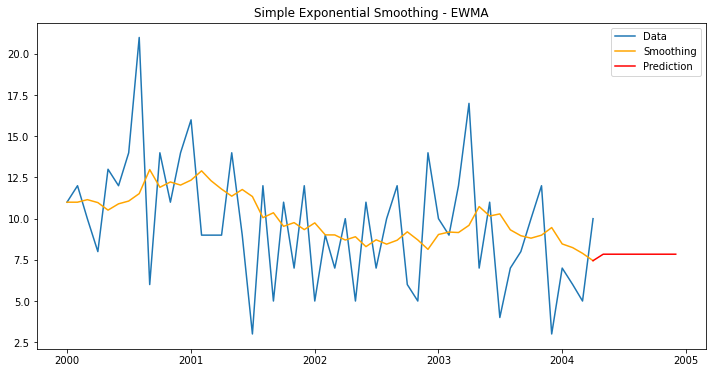

In [78]:
plt.plot(product_df, label='Data')
plt.plot(model_ewma.fittedvalues, color='orange', label='Smoothing')
plt.plot(future, color='red', label='Prediction')
plt.legend()
plt.title('Simple Exponential Smoothing - EWMA');

# ARIMA
* Describes a process with three terms:
  * Auto Regressive - Current Value is a weighted sum of past values
  * Integrated - Differencing
  * Moving average - White noise or shocks to a system gradually reduced with time
* ARIMA models described with 3 values:
  * ARIMA(p, d, q)
  * p = number of auto regressive terms
  * d = number of differences
  * q = number of moving average terms
* Intuition
  * Linear models need stationarity (i.e. remove auto correlation)
  * To achieve stationarity we take a difference of the series itself
  * Taking differences removes the trend - I Term
  * Sometimes we over difference and need to add back - MA term
  * Sometimes differencing doesn't go far enough - AR term
* Approaches to Determining ARIMA order:
Heuristic using ACF and PACF plots
  * Grid search with loss (AIC)
  * Automated Search with Pyramid (AutoARIMA)


## Product

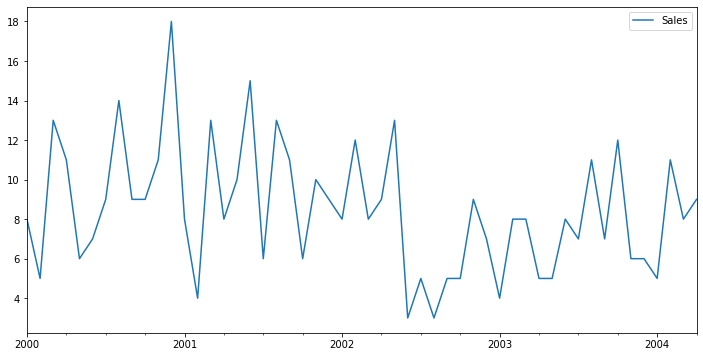

In [79]:
product_df = product_ts('P5')
product_df.plot();

## Decomposition

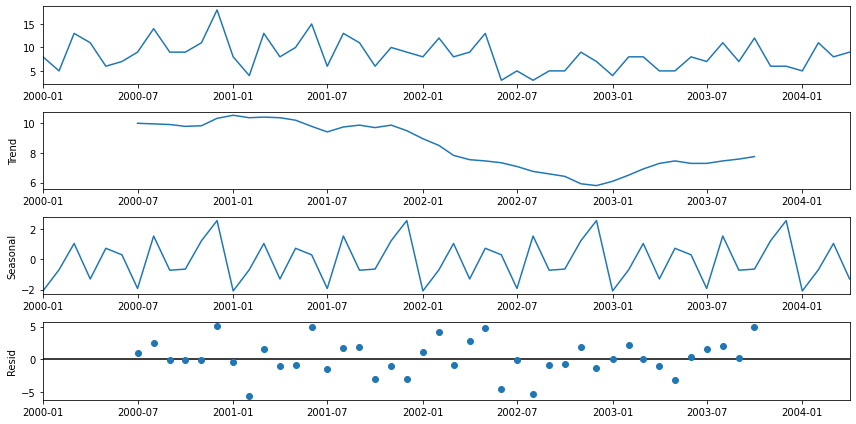

In [80]:
additive = seasonal_decompose(product_df, model='additive')
additive.plot();

## Stationarity
* Stationarity is an assumption built into many of the techniques used for time series
* It simply means there is **constant mean** (no trend) and **constant variance**
* There are statistical tests like Augmented Dickey Fuller which test for stationarity

In [81]:
def stationarity_test(values, critical = 0.05):
    results = adfuller(values)
    print(f'Augmented Dickey-Fuller Statistic {results[0]}')
    print(f'  p-value {results[1]}')
    print(f'  Lags used {results[2]}')
    print(f'  Number observations {results[3]}')
    if results[1] < critical:
        print('Strong evidence to reject no unit roots')
        print('There is stationarity')
    else:
        print('Weak evidence to reject no unit roots')
        print('There is not stationarity')

In [82]:
stationarity_test(product_df)

Augmented Dickey-Fuller Statistic -2.8386344016237213
  p-value 0.052963513173556936
  Lags used 2
  Number observations 49
Weak evidence to reject no unit roots
There is not stationarity


## Integrated - Differencing
* To make a time series stationary, we need to change it
* We can transform it (with Box Cox -- square, exponentiate, log)
* More customarily , we difference the sequence to make it stationary
* Differencing is the change between two consecutive data points in the series
* When we diff we lose a data point!!!

In [83]:
product_df['Diff-1'] = diff(product_df.Sales.astype(float))

In [84]:
product_df.head()

,Sales,Diff-1
2000-01-01,8,NaN
2000-02-01,5,-3.0
2000-03-01,13,8.0
2000-04-01,11,-2.0
2000-05-01,6,-5.0


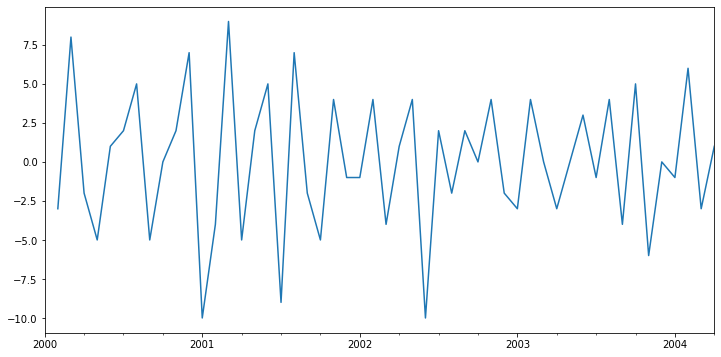

In [85]:
product_df['Diff-1'].plot()

In [86]:
product_df = product_df.dropna()
stationarity_test(product_df['Diff-1'])

Augmented Dickey-Fuller Statistic -4.722570553033894
  p-value 7.630982840821642e-05
  Lags used 6
  Number observations 44
Strong evidence to reject no unit roots
There is stationarity


## Auto Correlation Plot
* Data is perfectly correlated with itself at timestep t
* Data is slightly negatively correlated one timestep t-1
* Original data shows large autocorrelation - Take a difference & Check

Text(0.5, 1.0, 'AutoCorrelation Original Data')

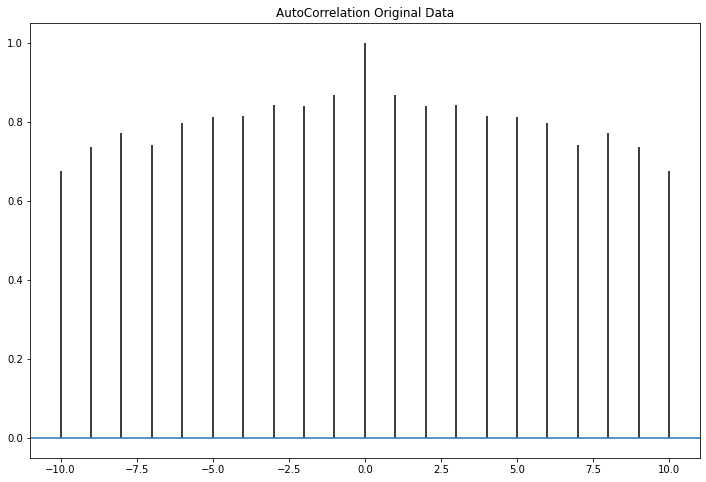

In [87]:
# Plot theoriginal data
plt.figure(figsize=(12,8))
plt.acorr(product_df.Sales.astype(float))
plt.title('AutoCorrelation Original Data')

Text(0.5, 1.0, 'AutoCorrelation Diff Data')

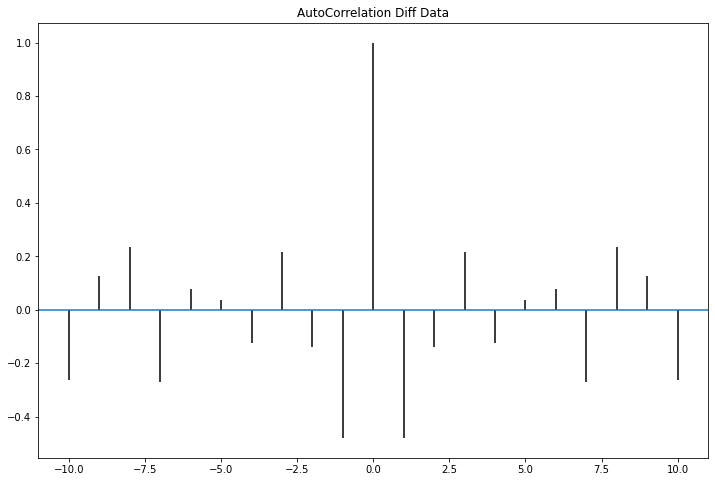

In [88]:
# Plot the differenced data
plt.figure(figsize=(12,8))
plt.acorr(product_df['Diff-1'].astype(float))
plt.title('AutoCorrelation Diff Data')

## MA - Moving Average
* Related to acorr plot (right hand-side)
* Stands for auto correlation function
* Also called a correlogram
* Shows serial correlation in the dataset
* Significance are indicated outside of shaded region
* MA Pattern:
  * Sharp cutoff
  * Lag 1 autocorrelation is negative
  * Series appears slightly over differenced
  * The lag at the ACF cutoff (of significance) indicates the number of terms
* This plot:
  * Lag 0 is at 1.0 (perfect correlation)
  * Lag 1 is negative and significant
  * Pattern indicates MA term of 1
  * Lag 12 significant - may indicate yearly seasonality

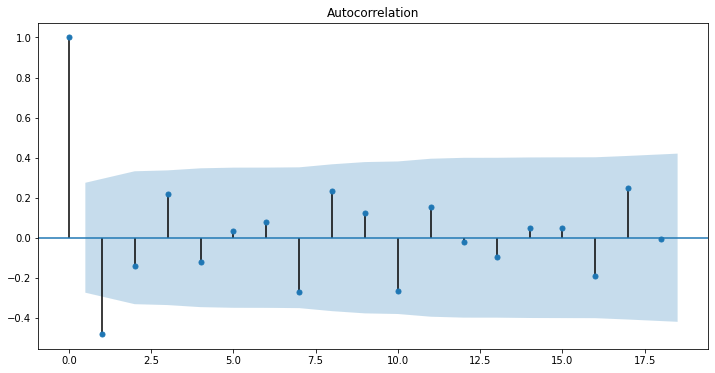

In [89]:
plot_acf(product_df['Diff-1']);

## AR - Auto Regressive
* Auto Regressive - PACF Plot
* PACF = Partial Auto Correlation Function Plot
* Measures the amount of correlation with each lag not accounted for by more recent lags
* For example PACF for Lag 0 and Lag 2 would measure the correlation between each while factoring out Lag 1
* AR Pattern:
  * Steep dropoff
  * Lag 1 positive
  * Series appears slightly under differenced
* This plot:
  * Steep dropoff
  * Negative Lag 1
  * Pattern doesn't indicate an AR term

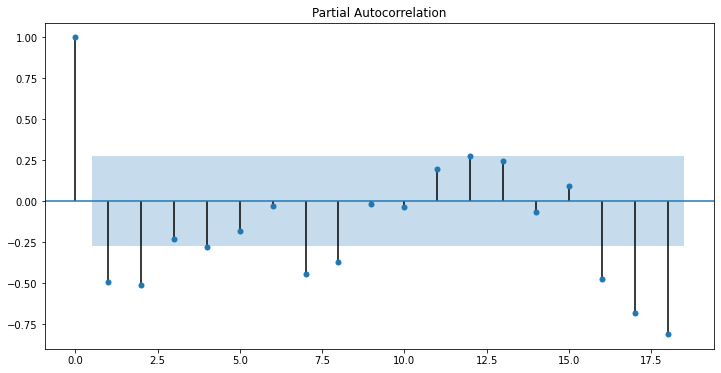

In [90]:
plot_pacf(product_df['Diff-1']);

## Heuristic Model
* http://people.duke.edu/~rnau/411arim.htm
* AR = 0 No strong AR pattern present
* I = 1 We found 1 difference as sufficient to acheive stationarity
* MA = 1 Found MA pattern in data
* Order (0, 1, 1)
* There appears to be a little seasonality in the data but we're stationary

In [91]:
model = ARIMA(product_df['Sales'], order=(0,1,1))
results = model.fit()

In [92]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   51
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -130.561
Date:                Tue, 31 Aug 2021   AIC                            265.121
Time:                        13:41:17   BIC                            268.945
Sample:                    02-01-2000   HQIC                           266.578
                         - 04-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8758      0.093     -9.432      0.000      -1.058      -0.694
sigma2        10.5425      2.206      4.778      0.000       6.218      14.867
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.72   Prob(JB):                         0.76
Heteroskedasticity (H):               0.35   Skew:                             0.25
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto-Arima
* Library that ports R's auto.arima functionality to the python landscape
* Saves you from having to read ACF and PACF plots
* Performs 
  * Differencing
  * Tests AR and MA terms
  * Tests seasonal parameters


In [93]:
auto_model = AutoARIMA(start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, trace=True)
auto_model.fit(product_df['Sales'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=295.363, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=284.764, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=293.380, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=273.447, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=273.753, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=269.230, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=270.671, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=267.330, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=266.750, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=265.121, Time=0.06 sec
 A

AutoARIMA(D=None, alpha=0.05, d=None, error_action='trace',
          information_criterion='aic', m=1, max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=3, max_q=3, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=None, scoring='mse', scoring_args=None, seasonal=False,
          seasonal_test='ocsb', seasonal_test_args=None, start_P=1, start_Q=1,
          start_p=0, start_params=None, ...)

In [94]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -130.561
Date:                Tue, 31 Aug 2021   AIC                            265.121
Time:                        13:41:21   BIC                            268.945
Sample:                             0   HQIC                           266.578
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8758      0.093     -9.432      0.000      -1.058      -0.694
sigma2        10.5425      2.206      4.778      0.000       6.218      14.867
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.72   Prob(JB):                         0.76
Heteroskedasticity (H):               0.35   Skew:                             0.25
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict

In [95]:
in_sample = auto_model.predict_in_sample(return_conf_int=True)
confint_df = pd.DataFrame(in_sample[1])
pred_df = product_df.copy()
pred_df['Prediction'] = in_sample[0]
pred_df['Low']  = confint_df[0].values
pred_df['High'] = confint_df[1].values
pred_df

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


,Sales,Diff-1,Prediction,Low,High
2000-02-01,5,-3.0,0.000000,-1959.982240,1959.982240
2000-03-01,13,8.0,4.999954,-3.459255,13.459163
2000-04-01,11,-2.0,9.034906,1.687794,16.382017
2000-05-01,6,-5.0,9.708868,2.762231,16.655505
2000-06-01,7,1.0,8.725918,1.981180,15.470656
2000-07-01,9,2.0,8.345583,1.719306,14.971859
2000-08-01,14,5.0,8.471389,1.920814,15.021964
2000-09-01,9,-5.0,9.430405,2.930862,15.929949
2000-10-01,9,0.0,9.361354,2.897460,15.825248
2000-11-01,11,2.0,9.306736,2.868369,15.745103


In [96]:
auto_model.predict(n_periods = 8)

array([7.84754434, 7.84754434, 7.84754434, 7.84754434, 7.84754434,
       7.84754434, 7.84754434, 7.84754434])

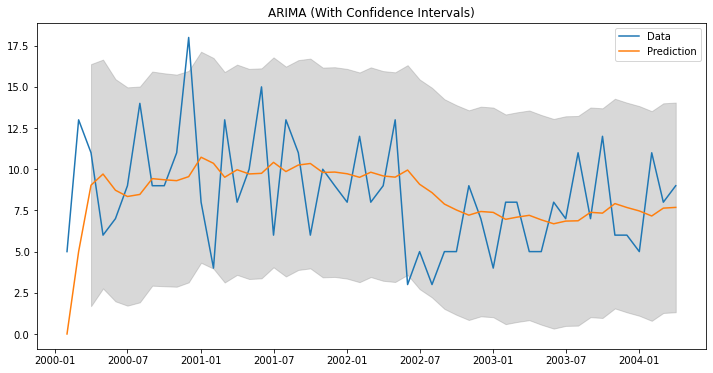

In [97]:
plt.plot(pred_df.Sales, label='Data')
plt.plot(pred_df.Prediction, label='Prediction')
plt.fill_between(pred_df.index, pred_df.Low, pred_df.High, 
                 where=(pred_df.Low > 0), color='gray', alpha=0.3)
plt.legend()
plt.title('ARIMA (With Confidence Intervals)');

# Testing Predictions
![](https://miro.medium.com/max/558/1*AXRu72CV1hdjLfODFGbMWQ.png)

# Future
* Machine Learning
* FBProphet
* Deep Learning
* Kats, sktime, tsfresh, tslearn

# Resources
* https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea